<a href="https://colab.research.google.com/github/JasonLaux/DeepGlobe/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import cv2 # 4.1.2
import tensorflow as tf # tf.__version__ = 2.6
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
# Python Version 3.7.12
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# Get the path of meta_data.csv.file
base_path = os.getcwd()
metadata_path = os.path.join(base_path, "drive/MyDrive/road-extraction/meta_data.csv")
dataset_path = os.path.join(base_path, "drive/MyDrive/road-extraction/Road_Extraction_Dataset.zip (Unzipped Files)")

In [65]:
meta_data = pd.read_csv(metadata_path, index_col=False)

train_dataset_index = meta_data[meta_data['split'] == 'train'][['sat', 'mask']]
test_dataset_index = meta_data[meta_data['split'] == 'test'][['sat', 'mask']]

num_train = len(train_dataset_index)
num_test = len(test_dataset_index)


print(meta_data.head(1))
print(train_dataset_index.head(1))


   split             sat             mask
0  train  100034_sat.jpg  100034_mask.png
              sat             mask
0  100034_sat.jpg  100034_mask.png


Original satellite image shape:  (1024, 1024, 3)
Grayscale mask image shape:  (1024, 1024)
Binary mask image: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


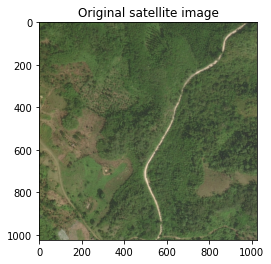

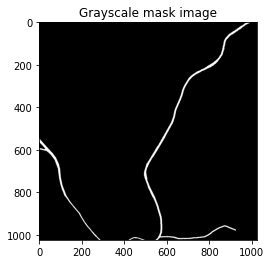

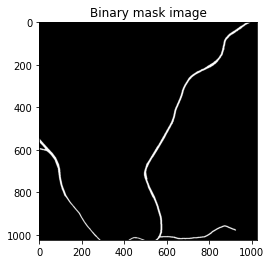

In [66]:
# Display the original image and the mask image in the first raw
example_sat_path = os.path.join(dataset_path, train_dataset_index.loc[0, 'sat'])
example_mask_path = os.path.join(dataset_path, train_dataset_index.loc[0, 'mask'])
sat = cv2.imread(example_sat_path)
mask = cv2.imread(example_mask_path, cv2.IMREAD_GRAYSCALE)
mask_bw = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]
print("Original satellite image shape: ", sat.shape)
print("Grayscale mask image shape: ", mask.shape)
print("Binary mask image: \n", mask_bw)
# fig, ax = plt.subplots(3, 1)
# ax[0].imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
# ax[0].set_title("Original satellite image")
# ax[1].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
# ax[1].set_title("Grayscale mask image")
# ax[2].imshow(mask_bw, cmap='gray')
# ax[2].set_title("Binary mask image(threshold value=128)")
# plt.show()

fig1 = plt.figure()
plt.imshow(cv2.cvtColor(sat, cv2.COLOR_BGR2RGB))
plt.title("Original satellite image")
fig2 = plt.figure()
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("Grayscale mask image")
fig3 = plt.figure()
plt.imshow(mask_bw, cmap='gray')
plt.title("Binary mask image")
plt.show()


In [71]:
width, height = 512, 512
input_scale = (width, height)
train_sat = np.empty([num_train, width, height, 3], dtype = int)
train_mask = np.empty([num_train, width, height, 1], dtype = int)

for i in range(num_train):
    # Read the satellite image and the cooresponding mask image
    sat = cv2.imread(os.path.join(dataset_path, train_dataset_index.loc[i, 'sat']))
    mask_gray = cv2.imread(os.path.join(dataset_path, train_dataset_index.loc[i, 'mask']), cv2.IMREAD_GRAYSCALE)

    # Binarize mask image. Threshold is 128.
    mask_bw = cv2.threshold(mask_gray, 128, 255, cv2.THRESH_BINARY)[1]

    resized_sat= cv2.resize(sat, input_scale, interpolation = cv2.INTER_CUBIC)
    resized_mask= cv2.resize(mask_bw, input_scale, interpolation = cv2.INTER_CUBIC)

    # Expand another dim 
    resized_mask = np.expand_dims(resized_mask, axis=-1)

    train_sat[i] = resized_sat
    train_mask[i] = resized_mask

    if (i + 1) % 100 == 0:
      print("Total number of samples that has been processed: ", i + 1)

print(train_sat.shape)
print(train_mask.shape)

Total number of samples that has been processed:  100
Total number of samples that has been processed:  200
Total number of samples that has been processed:  300


KeyboardInterrupt: ignored

In [62]:
class Autoencoder:
	
	def build(width, height, depth, filters=(32, 64, 128), latentDim=16):
		# initialize the input shape
		inputShape = (height, width, depth)
		chanDim = -1
		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs
		# construct encoder
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (5, 5), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
	
		# loop through filters in the reverse order to construct decoder
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (5, 5), strides=2,
				padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)
		# apply a single CONV_TRANSPOSE layer used to recover the
		# binary mask image
		x = Conv2DTranspose(1, (5, 5), padding="same")(x)
		outputs = Activation("sigmoid", name="decoded")(x)
		# construct our autoencoder model
		autoencoder = Model(inputs, outputs, name="autoencoder")
		# return the autoencoder model
		return autoencoder

In [63]:
autoencoder = Autoencoder.build(512, 512, 3)
autoencoder.summary()
autoencoder.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 32)      2432      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 64)      51264     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 64)      